In [1]:
## Import packages
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # if using multi-GPU

## GSP-HAR

In [3]:
data = pd.read_csv('rv5_sqrt_24.csv', index_col = 0)*100
date_list = data.index.tolist()
train_end_idx = int(len(date_list)*0.7)
train_dataset = data.iloc[0:train_end_idx,:]
test_dataset = data.iloc[train_end_idx:,:]
market_indices_list = train_dataset.columns.tolist()

In [4]:
from scipy.sparse import linalg
from statsmodels.tsa.api import VAR
from scipy import stats

def compute_spillover_index(data, horizon, lag, scarcity_prop, standardized=True):
    # Input data should be np.array
    data_array = data.values
    # Fit VAR model
    model = VAR(data_array)
    results = model.fit(maxlags=lag)
    
    # Manually Compute Forecast Error Variance Decomposition (FEVD)
    Sigma = results.sigma_u
    A = results.orth_ma_rep(maxn=horizon - 1)
    
    Sigma_A = []
    A_Sigma_A = []
    
    for h in range(horizon):
        # Numerator
        Sigma_A_h = (A[h] @ Sigma @ np.linalg.inv(np.diag(np.sqrt(np.diag(Sigma))))) ** 2
        Sigma_A.append(Sigma_A_h)
        
        # Denominator
        A_Sigma_A_h = A[h] @ Sigma @ A[h].T
        A_Sigma_A.append(A_Sigma_A_h)
    
    # Numerator: cumulative sum of Sigma_A
    num = np.cumsum(Sigma_A, axis=0)
    
    # Denominator: cumulative sum of A_Sigma_A
    den = np.cumsum(A_Sigma_A, axis=0)
    
    # Generalized FEVD
    gfevd = np.array([num[h] / np.diag(den[h])[:, None] for h in range(horizon)])
    
    if standardized:
        # Standardize each FEVD matrix so that each row sums to 1
        gfevd = np.array([fevd / fevd.sum(axis=1, keepdims=True) for fevd in gfevd])
    
    # Aggregate results over n_ahead steps
    spillover_matrix = gfevd[-1]
    
    # VSP from row to column so can be used as adjacency matrix
    spillover_matrix = spillover_matrix.T ## row --> column: if node i --> node j, A_{ij} != 0
    
    # Convert to percentage
    spillover_matrix *= 100      
    
    # Calculate 'to' and 'from' others
    K = spillover_matrix.shape[0]
    
    # Create results DataFrame
    results_df = pd.DataFrame(spillover_matrix, columns=results.names, index=results.names)
    
    # Increase sparcity
    vsp_df_sparse = results_df.copy()
    threshold = pd.Series(results_df.values.flatten()).quantile(scarcity_prop)
    vsp_df_sparse[vsp_df_sparse < threshold] = 0
    vsp_np_sparse = vsp_df_sparse.values
    np.fill_diagonal(vsp_np_sparse, 0)

    if standardized:
        vsp_np_sparse = vsp_np_sparse / K
        return vsp_np_sparse
    else:
        return vsp_np_sparse # for each train_x batch, dim(results_array) = [num_node, num_node]

In [5]:
corr_adj_mx = compute_spillover_index(train_dataset, 1, 22, 0.0, standardized=True)
A = (corr_adj_mx - corr_adj_mx.T)
A[A < 0] = 0
# Graph process
from scipy.linalg import sqrtm
def nomalized_magnet_laplacian(A, q, norm = True):
    A_s = (A + A.T)/2
    D_s = np.diag(np.sum(A_s, axis=1))
    pi = np.pi
    theta_q = 2 * pi * q * (A - A.T)
    H_q = A_s * np.exp(1j*theta_q)
    if norm == True:
        D_s_inv = np.linalg.inv(D_s)
        D_s_inv_sqrt = sqrtm(D_s_inv)
        L = np.eye(len(D_s)) - (D_s_inv_sqrt @ A_s @ D_s_inv_sqrt) * np.exp(1j*theta_q)
    else:
        L = D_s - H_q

    return L

L = nomalized_magnet_laplacian(A,0.25)

from scipy.linalg import eig
eigenvalues, eigenvectors = eig(L)

Lambda = eigenvalues.real
U_dega = eigenvectors
U = eigenvectors.T.conj()

# Sort the eigenvalues (Lambda) and get the indices of the sorted order
sorted_indices = np.argsort(Lambda)  # Sort in ascending order

# Reorder Sigma, U, and U_dega
Lambda_sorted = Lambda[sorted_indices]  
U_sorted = U[:, sorted_indices]   
U_dega_sorted = U_dega[sorted_indices, :]

# Convert sorted Sigma into a diagonal matrix
Lambda_matrix_sorted = np.diag(Lambda_sorted)

Lambda = Lambda_matrix_sorted
U_dega = U_dega_sorted
U = U_sorted

In [6]:
## Save model
def save_model(name, model, num_L = None, best_loss_val = None):
    if not os.path.exists('models/'):
            os.makedirs('models/')
    # Prepare the model state dictionary
    config = {
        'model_state_dict': model.state_dict(),
        'layer': num_L,
        'loss': best_loss_val
    }
    # Save the model state dictionary
    torch.save(config, f'models/{name}.tar')
    return

## Load model
def load_model(name, model):
    checkpoint = torch.load(f'models/{name}.tar', map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    num_L = checkpoint['layer']
    mae_loss = checkpoint['loss']
    print(f"Loaded model: {name}")
    print(f"MAE loss: {mae_loss}")
    return model, mae_loss

In [7]:
look_back_window = 22
for market_index in market_indices_list:
    for lag in range(look_back_window):
        train_dataset[market_index + f'_{lag+1}'] = train_dataset[market_index].shift(lag+1)
        test_dataset[market_index + f'_{lag+1}'] = test_dataset[market_index].shift(lag+1)

train_dataset = train_dataset.dropna()
test_dataset = test_dataset.dropna()

In [8]:
columns_lag1 = [x for x in train_dataset.columns.tolist() if x[-2:] == '_1']
columns_lag5 = [x for x in train_dataset.columns.tolist() if (x[-2]=='_') and (float(x[-1]) in range(1,6))]
columns_lag22 = [x for x in train_dataset.columns.tolist() if '_' in x]
x_columns = columns_lag1 + columns_lag5 + columns_lag22
y_columns = [x for x in train_dataset.columns.tolist() if x not in x_columns]
row_index_order = market_indices_list
column_index_order_5 = [f'lag_{i}' for i in range(1,6)]
column_index_order_22 = [f'lag_{i}' for i in range(1,23)]


train_dict = {}
for date in train_dataset.index:
    y = train_dataset.loc[date,y_columns]
    
    x_lag1 = train_dataset.loc[date,columns_lag1]
    new_index = [ind[:-2] for ind in x_lag1.index.tolist()]
    x_lag1.index = new_index
    
    x_lag5 = train_dataset.loc[date,columns_lag5]

    # Split the index into market indices and lags
    data_lag5 = {
    'Market': [index.split('_')[0] for index in x_lag5.index],
    'Lag': [f'lag_{index.split("_")[1]}' for index in x_lag5.index],
    'Value': x_lag5.values
    }
    # Convert to DataFrame
    df_lag5 = pd.DataFrame(data_lag5)
    # Pivot the DataFrame
    df_lag5 = df_lag5.pivot(index='Market', columns='Lag', values='Value')

    x_lag22 = train_dataset.loc[date,columns_lag22]
    # Split the index into market indices and lags
    data_lag22 = {
    'Market': [index.split('_')[0] for index in x_lag22.index],
    'Lag': [f'lag_{index.split("_")[1]}' for index in x_lag22.index],
    'Value': x_lag22.values
    }
    # Convert to DataFrame
    df_lag22 = pd.DataFrame(data_lag22)
    # Pivot the DataFrame
    df_lag22 = df_lag22.pivot(index='Market', columns='Lag', values='Value')

    x_lag1 = x_lag1.reindex(row_index_order)
    df_lag5 = df_lag5.reindex(row_index_order)
    df_lag22= df_lag22.reindex(row_index_order)
    df_lag5 = df_lag5[column_index_order_5]
    df_lag22 = df_lag22[column_index_order_22]
    
    dfs_dict = {
        'y': y,
        'x_lag1': x_lag1,
        'x_lag5': df_lag5,
        'x_lag22': df_lag22
    }
    train_dict[date] = dfs_dict

test_dict = {}
for date in test_dataset.index:
    y = test_dataset.loc[date,y_columns]
    
    x_lag1 = test_dataset.loc[date,columns_lag1]
    new_index = [ind[:-2] for ind in x_lag1.index.tolist()]
    x_lag1.index = new_index
    
    x_lag5 = test_dataset.loc[date,columns_lag5]
    # Split the index into market indices and lags
    data_lag5 = {
    'Market': [index.split('_')[0] for index in x_lag5.index],
    'Lag': [f'lag_{index.split("_")[1]}' for index in x_lag5.index],
    'Value': x_lag5.values
    }
    # Convert to DataFrame
    df_lag5 = pd.DataFrame(data_lag5)
    # Pivot the DataFrame
    df_lag5 = df_lag5.pivot(index='Market', columns='Lag', values='Value')

    x_lag22 = test_dataset.loc[date,columns_lag22]
    # Split the index into market indices and lags
    data_lag22 = {
    'Market': [index.split('_')[0] for index in x_lag22.index],
    'Lag': [f'lag_{index.split("_")[1]}' for index in x_lag22.index],
    'Value': x_lag22.values
    }
    # Convert to DataFrame
    df_lag22 = pd.DataFrame(data_lag22)
    # Pivot the DataFrame
    df_lag22 = df_lag22.pivot(index='Market', columns='Lag', values='Value')

    x_lag1 = x_lag1.reindex(row_index_order)
    df_lag5 = df_lag5.reindex(row_index_order)
    df_lag22= df_lag22.reindex(row_index_order)
    df_lag5 = df_lag5[column_index_order_5]
    df_lag22 = df_lag22[column_index_order_22]
    
    dfs_dict = {
        'y': y,
        'x_lag1': x_lag1,
        'x_lag5': df_lag5,
        'x_lag22': df_lag22
    }
    test_dict[date] = dfs_dict

In [9]:
class GSPHAR_Dataset(Dataset):
    def __init__(self, dict):
        self.dict = dict

    def __len__(self):
        return len(self.dict.keys())

    def __getitem__(self, idx):
        date = list(self.dict.keys())[idx]
        dfs_dict = self.dict[date]
        y = dfs_dict['y'].values
        x_lag1 = dfs_dict['x_lag1'].values
        x_lag5 = dfs_dict['x_lag5'].values
        x_lag22 = dfs_dict['x_lag22'].values
        
        y_tensor = torch.tensor(y, dtype=torch.float32)
        x_lag1_tensor = torch.tensor(x_lag1, dtype=torch.float32)
        x_lag5_tensor = torch.tensor(x_lag5, dtype=torch.float32)
        x_lag22_tensor = torch.tensor(x_lag22, dtype=torch.float32)
        return x_lag1_tensor, x_lag5_tensor, x_lag22_tensor, y_tensor

# Create dataset and dataloader
dataset_train = GSPHAR_Dataset(train_dict)
dataset_test = GSPHAR_Dataset(test_dict)

In [10]:
class GSPHAR(nn.Module):
    # linear transformation
    def __init__ (self, input_dim, output_dim, filter_size, U, U_dega):
        super(GSPHAR,self).__init__()
        self.filter_size = filter_size
        self.U = torch.complex(torch.tensor(U.real, dtype=torch.float32), torch.tensor(U.imag, dtype=torch.float32))
        self.U_dega = torch.complex(torch.tensor(U_dega.real, dtype=torch.float32), torch.tensor(U_dega.imag, dtype=torch.float32))
        self.conv1d_lag5 = nn.Conv1d(in_channels = filter_size, out_channels = filter_size, kernel_size = 5, groups = filter_size, bias = False) # groups=1 markets share similarity
        nn.init.constant_(self.conv1d_lag5.weight, 1.0 / 5)
        self.conv1d_lag22 = nn.Conv1d(in_channels = filter_size, out_channels = filter_size, kernel_size = 22, groups = filter_size, bias = False) # groups=1
        nn.init.constant_(self.conv1d_lag22.weight, 1.0 / 22)
        self.spatial_process = nn.Sequential(
            nn.Linear(2, 2 * 8),
            nn.ReLU(),
            nn.Linear(2 * 8, 2 * 8),
            nn.ReLU(),
            nn.Linear(2 * 8, 1),
            nn.ReLU()
        )
        self.linear_output = nn.Linear(input_dim, output_dim, bias=True)
        
    def forward(self, x_lag1, x_lag5, x_lag22):
        # Ensure all items are on the same device as the input x
        device = x_lag1.device
        U = self.U.to(device)
        U_dega = self.U_dega.to(device)
        self.conv1d_lag5 = self.conv1d_lag5.to(device)
        self.conv1d_lag22 = self.conv1d_lag22.to(device)
        self.spatial_process = self.spatial_process.to(device)
        self.linear_output_real = self.linear_output.to(device)
        self.linear_output_imag = self.linear_output.to(device)
    
        # Convert RV to complex domain
        x_lag1 = torch.complex(x_lag1, torch.zeros_like(x_lag1))
        x_lag5 = torch.complex(x_lag5, torch.zeros_like(x_lag5))
        x_lag22 = torch.complex(x_lag22, torch.zeros_like(x_lag22))

        # Spectral domain operations on lag-5
        x_lag5 = torch.matmul(U_dega, x_lag5)
        exp_param_5 = torch.exp(self.conv1d_lag5.weight)
        sum_exp_param_5 = torch.sum(exp_param_5, dim=-1, keepdim=True)
        softmax_param_5 = exp_param_5/sum_exp_param_5
        x_lag5_real = F.conv1d(input=x_lag5.real, weight=softmax_param_5, bias=None, groups=self.filter_size)
        x_lag5_imag = F.conv1d(input=x_lag5.imag, weight=softmax_param_5, bias=None, groups=self.filter_size)
        x_lag5 = torch.complex(x_lag5_real, x_lag5_imag)
        x_lag5 = x_lag5.squeeze(-1)

        # Spectral domain operations on lag-22
        x_lag22 = torch.matmul(U_dega, x_lag22)
        exp_param_22 = torch.exp(self.conv1d_lag22.weight)
        sum_exp_param_22 = torch.sum(exp_param_22, dim=-1, keepdim=True)
        softmax_param_22 = exp_param_22/sum_exp_param_22
        x_lag22_real = F.conv1d(input=x_lag22.real, weight=softmax_param_22, bias=None, groups=self.filter_size)
        x_lag22_imag = F.conv1d(input=x_lag22.imag, weight=softmax_param_22, bias=None, groups=self.filter_size)
        x_lag22 = torch.complex(x_lag22_real, x_lag22_imag)
        x_lag22 = x_lag22.squeeze(-1)

        # Lag-1 processing
        x_lag1 = torch.matmul(U_dega, x_lag1.unsqueeze(-1))
        x_lag1 = x_lag1.squeeze(-1)

        # Combine lagged responses in the spectral domain
        lagged_rv_spectral = torch.stack((x_lag1, x_lag5, x_lag22), dim=-1)
        
        # Apply linear transformation separately to the real and imaginary parts
        y_hat_real = self.linear_output_real(lagged_rv_spectral.real)
        y_hat_imag = self.linear_output_imag(lagged_rv_spectral.imag)
        y_hat_spectral = torch.complex(y_hat_real, y_hat_imag)

        # Back to the spatial domain
        y_hat = torch.matmul(U, y_hat_spectral)

        y_hat_real = y_hat.real # [batch_size, num_markets, 1]
        y_hat_imag = y_hat.imag # [batch_size, num_markets, 1]
        y_hat_real = y_hat_real.squeeze(-1)
        y_hat_imag = y_hat_imag.squeeze(-1)
        
        y_hat_spatial = torch.stack((y_hat_real, y_hat_imag), dim=-1)
        
        # Apply linear transformation separately to the real and imaginary parts
        y_hat = self.spatial_process(y_hat_spatial)
        
        return y_hat.squeeze(-1), softmax_param_5, softmax_param_22

In [11]:
def train_eval_model(model, dataloader_train, dataloader_test, num_epochs = 200, lr = 0.01):
    best_loss_val = 1000000
    patience = 0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, 
                                                   steps_per_epoch=len(dataloader_train), epochs = num_epochs,
                                                   three_phase=True)
    model.to(device)
    criterion = nn.MSELoss()
    criterion = criterion.to(device)
    model.train()
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        for x_lag1, x_lag5, x_lag22, y in dataloader_train:
            x_lag1 = x_lag1.to(device)
            x_lag5 = x_lag5.to(device)
            x_lag22 = x_lag22.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output, conv1d_lag5_weights, conv1d_lag22_weights = model(x_lag1, x_lag5, x_lag22)
            loss = criterion(output, y)
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Update scheduler: this scheduler is designed to be updated after each batch.
            scheduler.step()
        
        # Evaluate model
        valid_loss = evaluate_model(model, dataloader_test)

        if valid_loss < best_loss_val:
            best_loss_val = valid_loss
            final_conv1d_lag5_weights = conv1d_lag5_weights.detach().cpu().numpy()
            final_conv1d_lag22_weights = conv1d_lag22_weights.detach().cpu().numpy()
            patience = 0
            save_model('GSPHAR_24_magnet_h1', model, None, best_loss_val)
        else:
            patience = patience + 1
            if patience >= 50:
                print(f'early stopping at epoch {epoch+1}.')
                break
            else:
                pass
    return best_loss_val, final_conv1d_lag5_weights, final_conv1d_lag22_weights


# Evaluate model
def evaluate_model(model, dataloader_test):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.L1Loss()
    criterion = criterion.to(device)
    valid_loss = 0
    model.eval()
    with torch.no_grad():
        for x_lag1, x_lag5, x_lag22, y in dataloader_test:
            x_lag1 = x_lag1.to(device)
            x_lag5 = x_lag5.to(device)
            x_lag22 = x_lag22.to(device)
            y = y.to(device)
            output, _, _ = model(x_lag1, x_lag5, x_lag22)
            loss = criterion(output, y)
            valid_loss = valid_loss + loss.item()
    valid_loss = valid_loss/len(dataloader_test)
    return valid_loss

In [12]:
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [13]:
input_dim = 3
output_dim = 1
filter_size = 24
num_epochs = 100
lr = 0.01

GSPHAR_RV = GSPHAR(input_dim,output_dim, filter_size, U, U_dega)
valid_loss, final_conv1d_lag5_weights, final_conv1d_lag22_weights = train_eval_model(GSPHAR_RV, dataloader_train, dataloader_test, num_epochs, lr)
trained_GSPHAR, mae_GSPHAR  = load_model('GSPHAR_24_magnet_h1',GSPHAR_RV) 

early stopping at epoch 78.
Loaded model: GSPHAR_24_magnet_h1
MAE loss: 0.17869430780410767


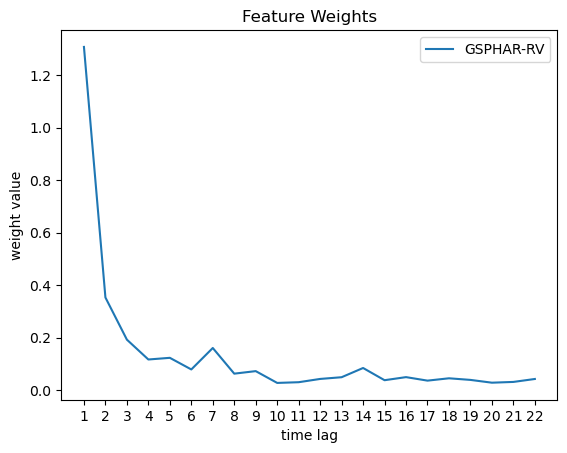

In [14]:
j = 0
coef_list = []
for i in range(22):
    j = 1+i
    if j == 1:
        coef = 1 + final_conv1d_lag5_weights.T[i].mean() + final_conv1d_lag22_weights.T[i].mean()
    elif j <= 5 and j > 1:
        coef = final_conv1d_lag5_weights.T[i].mean() + final_conv1d_lag22_weights.T[i].mean()
    else:
        coef = final_conv1d_lag22_weights.T[i].mean()
    coef_list.append(coef)

import matplotlib.pyplot as plt
# Assuming coef_list is already defined
plt.plot(coef_list, label="GSPHAR-RV")
# Add labels for the axes
plt.xlabel('time lag')
plt.ylabel('weight value')
# Add a title to the graph
plt.title('Feature Weights')
# Set the x-axis ticks shifted by 0.5 for better alignment
plt.xticks(ticks=[i for i in range(len(coef_list))], labels=range(1, len(coef_list) + 1))
# Add a legend
plt.legend()
# Display the plot
plt.show()

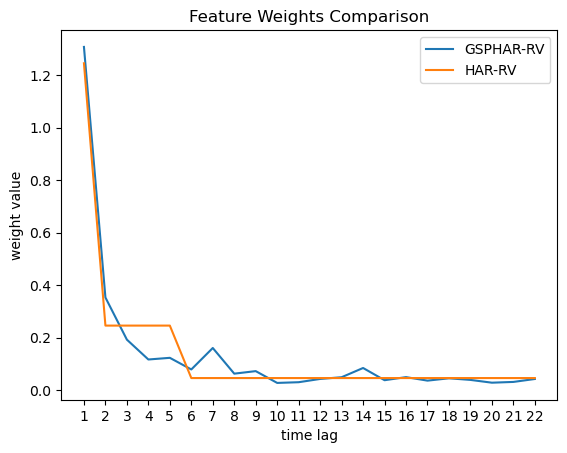

In [15]:
HAR_coef_list = []
for i in range(0,22):
    if i + 1 < 2:
        HAR_coef_list.append(1+1/5+1/22)
    elif i + 1 < 6:
        HAR_coef_list.append(1/5+1/22)
    else:
        HAR_coef_list.append(1/22)
        
import matplotlib.pyplot as plt
# Assuming coef_list is already defined
plt.plot(coef_list, label="GSPHAR-RV")
plt.plot(HAR_coef_list, label="HAR-RV")

# Add labels for the axes
plt.xlabel('time lag')
plt.ylabel('weight value')
# Add a title to the graph
plt.title('Feature Weights Comparison')

# Set the x-axis ticks shifted by 0.5 for better alignment
plt.xticks(ticks=[i for i in range(len(coef_list))], labels=range(1, len(coef_list) + 1))

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [16]:
y_hat_list = []
y_list = []

trained_GSPHAR.eval()

with torch.no_grad():
    for x_lag1, x_lag5, x_lag22, y in dataloader_test:
        y_hat, _, _ = trained_GSPHAR(x_lag1, x_lag5, x_lag22)
        
       # Append the predicted and actual values to their respective lists
        y_hat_list.append(y_hat.cpu().numpy())
        y_list.append(y.cpu().numpy())

In [17]:
y_hat_concatenated = np.concatenate(y_hat_list, axis=0)
y_concatenated = np.concatenate(y_list, axis=0)

rv_hat_GSPHAR = pd.DataFrame(data = y_hat_concatenated, columns = market_indices_list)
rv_true = pd.DataFrame(data = y_concatenated, columns = market_indices_list)

In [18]:
pred_GSPHAR_df = pd.DataFrame()
for market_index in market_indices_list:
    pred_column = market_index+'_rv_forecast'
    true_column = market_index+'_rv_true'
    pred_GSPHAR_df[pred_column] = rv_hat_GSPHAR[market_index]
    pred_GSPHAR_df[true_column] = rv_true[market_index]